# Spoken Language Understanding 

## Requirements

In [1]:
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from pathlib import Path
from wav2vec2 import Wav2Vec2Config

config = Wav2Vec2Config()

print("TF version:", tf.__version__)

TF version: 2.9.2


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Read FSC Data

In [61]:
data_path = Path("../fluent_speech_commands_dataset")
train_data_path = data_path / "data/train_data.csv"
train_data_df = pd.read_csv(train_data_path)

In [62]:
train_data_df.head(10)

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none
1,1,wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...,2BqVo8kVB2Skwgyb,Resume,activate,music,none
2,2,wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...,2BqVo8kVB2Skwgyb,Turn the lights on,activate,lights,none
3,3,wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...,2BqVo8kVB2Skwgyb,Switch on the lights,activate,lights,none
4,4,wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-1...,2BqVo8kVB2Skwgyb,Switch off the lights,deactivate,lights,none
5,5,wavs/speakers/2BqVo8kVB2Skwgyb/269fc210-4474-1...,2BqVo8kVB2Skwgyb,Volume up,increase,volume,none
6,6,wavs/speakers/2BqVo8kVB2Skwgyb/5bbda3f0-4478-1...,2BqVo8kVB2Skwgyb,Turn the volume up,increase,volume,none
7,7,wavs/speakers/2BqVo8kVB2Skwgyb/6436ad60-4478-1...,2BqVo8kVB2Skwgyb,Turn the volume down,decrease,volume,none
8,8,wavs/speakers/2BqVo8kVB2Skwgyb/6a1cd6f0-4478-1...,2BqVo8kVB2Skwgyb,Turn up the temperature,increase,heat,none
9,9,wavs/speakers/2BqVo8kVB2Skwgyb/72160200-4478-1...,2BqVo8kVB2Skwgyb,Turn the heat up,increase,heat,none


In [63]:
train_data_df = train_data_df.sample(frac=1).reset_index(drop=True)

In [64]:
train_data_df.head(10)

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,20718,wavs/speakers/xwzgmmv5ZOiVaxXz/1939aa20-453a-1...,xwzgmmv5ZOiVaxXz,Turn the lamp on,activate,lamp,none
1,40,wavs/speakers/2BqVo8kVB2Skwgyb/dead3b90-4478-1...,2BqVo8kVB2Skwgyb,Turn on the bathroom lights,activate,lights,washroom
2,10811,wavs/speakers/kxgXN97ALmHbaezp/a7aefec0-4465-1...,kxgXN97ALmHbaezp,Decrease the heating in the kitchen,decrease,heat,kitchen
3,15867,wavs/speakers/R3mXwwoaX9IoRVKe/dbddf870-4548-1...,R3mXwwoaX9IoRVKe,Lights off in the kitchen,deactivate,lights,kitchen
4,21180,wavs/speakers/YbmvamEWQ8faDPx2/f4b9b050-45e8-1...,YbmvamEWQ8faDPx2,Fetch my shoes,bring,shoes,none
5,1341,wavs/speakers/5BEzPgPKe8taG9OB/25053e80-457d-1...,5BEzPgPKe8taG9OB,Decrease the heating in the bathroom,decrease,heat,washroom
6,4803,wavs/speakers/AY5e3mMgZkIyG3Ox/66bedfe0-446d-1...,AY5e3mMgZkIyG3Ox,Too loud,decrease,volume,none
7,8873,wavs/speakers/gvKeNY2D3Rs2jRdL/1a4baa30-4599-1...,gvKeNY2D3Rs2jRdL,Make it louder,increase,volume,none
8,16282,wavs/speakers/R3mXwwoaX9IoRVKe/36656e90-4553-1...,R3mXwwoaX9IoRVKe,Set my phone's language to Chinese,change language,Chinese,none
9,10976,wavs/speakers/kxgXN97ALmHbaezp/9d988710-4467-1...,kxgXN97ALmHbaezp,Too quiet,increase,volume,none


## Targets

In [65]:
slots = ['action', 'object', 'location']
action_object_location = [train_data_df[slot].unique() for slot in slots]

In [66]:
action_object_location

[array(['activate', 'decrease', 'deactivate', 'bring', 'increase',
        'change language'], dtype=object),
 array(['lamp', 'lights', 'heat', 'shoes', 'volume', 'Chinese', 'juice',
        'music', 'socks', 'English', 'newspaper', 'none', 'German',
        'Korean'], dtype=object),
 array(['none', 'washroom', 'kitchen', 'bedroom'], dtype=object)]

In [67]:
from itertools import chain

targets = list(chain.from_iterable(action_object_location))
targets

['activate',
 'decrease',
 'deactivate',
 'bring',
 'increase',
 'change language',
 'lamp',
 'lights',
 'heat',
 'shoes',
 'volume',
 'Chinese',
 'juice',
 'music',
 'socks',
 'English',
 'newspaper',
 'none',
 'German',
 'Korean',
 'none',
 'washroom',
 'kitchen',
 'bedroom']

### Encode Targets

Add special tokens for start and end of sequence

In [68]:
sos = 0
eos = 1
target_to_index = {target: i+2 for i, target in enumerate(targets)}
index_to_target = {index: target for target, index in target_to_index.items()}

In [69]:
action_object_location = list(zip(train_data_df['action'], train_data_df['object'], train_data_df['location']))
full_targets = np.asarray([[sos, target_to_index[action], target_to_index[obj], target_to_index[location], eos] for action, obj, location in action_object_location])

In [70]:
full_targets

array([[ 0,  2,  8, 22,  1],
       [ 0,  2,  9, 23,  1],
       [ 0,  3, 10, 24,  1],
       ...,
       [ 0,  2,  9, 25,  1],
       [ 0,  4,  9, 25,  1],
       [ 0,  7, 17, 22,  1]])

### Create Tiny DataSet

Tiny ds for proof of concept

In [ ]:
BATCH_SIZE = 8
TINY_SIZE = 128
AUDIO_MAXLEN = 246000

In [73]:
data_path / train_data_df['path'][0]

PosixPath('../fluent_speech_commands_dataset/wavs/speakers/xwzgmmv5ZOiVaxXz/1939aa20-453a-11e9-b1e4-e5985dca719e.wav')

In [74]:
wav_files = train_data_df['path'][:TINY_SIZE+1].apply(lambda x: str(data_path / x))

In [85]:
wav, sample_rate = tf.audio.decode_wav(tf.io.read_file(wav_files[3]))
wav.shape, sample_rate

(TensorShape([49152, 1]), <tf.Tensor: shape=(), dtype=int32, numpy=16000>)

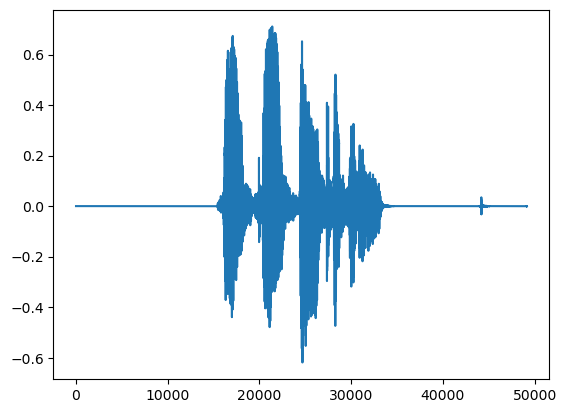

In [86]:
plt.plot(np.squeeze(wav.numpy()))
plt.show()

Pre-process data according to what Wav2Vec expects

In [87]:
from wav2vec2 import Wav2Vec2Processor

processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_speech(file_path):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    return processor(tf.transpose(audio))

In [105]:
speech_ds = tf.data.Dataset.from_tensor_slices(wav_files).map(preprocess_speech, num_parallel_calls=tf.data.AUTOTUNE)
speech_ds = speech_ds.padded_batch(BATCH_SIZE, padded_shapes=AUDIO_MAXLEN, padding_values=0.0)

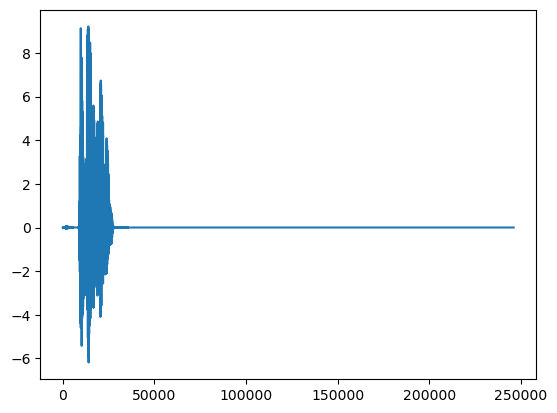

In [114]:
plt.plot(next(iter(speech_ds))[15])
plt.show()

## Create Targets

* Decoder input is the target sequence without the EOS token 
* The output or prediction is the one-step ahead target sequence (predicts the next token)

In [90]:
def split_targets(target):
    return target[:-1], target[1:]

In [91]:
targets_next_targets = [split_targets(full_target) for full_target in full_targets[:TINY_SIZE]]
targets, next_targets = zip(*targets_next_targets)
targets = list(targets)
next_targets = list(next_targets)

In [92]:
full_targets[:4], targets[:10], next_targets[:10]

(array([[ 0,  2,  8, 22,  1],
        [ 0,  2,  9, 23,  1],
        [ 0,  3, 10, 24,  1],
        [ 0,  4,  9, 24,  1]]),
 [array([ 0,  2,  8, 22]),
  array([ 0,  2,  9, 23]),
  array([ 0,  3, 10, 24]),
  array([ 0,  4,  9, 24]),
  array([ 0,  5, 11, 22]),
  array([ 0,  3, 10, 23]),
  array([ 0,  3, 12, 22]),
  array([ 0,  6, 12, 22]),
  array([ 0,  7, 13, 22]),
  array([ 0,  6, 12, 22])],
 [array([ 2,  8, 22,  1]),
  array([ 2,  9, 23,  1]),
  array([ 3, 10, 24,  1]),
  array([ 4,  9, 24,  1]),
  array([ 5, 11, 22,  1]),
  array([ 3, 10, 23,  1]),
  array([ 3, 12, 22,  1]),
  array([ 6, 12, 22,  1]),
  array([ 7, 13, 22,  1]),
  array([ 6, 12, 22,  1])])

In [93]:
target_ds = tf.data.Dataset.from_tensor_slices(targets).batch(BATCH_SIZE)
next_target_ds = tf.data.Dataset.from_tensor_slices(next_targets).batch(BATCH_SIZE)

In [94]:
train_ds = tf.data.Dataset.zip((speech_ds, target_ds, next_target_ds))

In [95]:
def gerate_inputs_and_target(speech, target, next_target):
    return {"speech": speech, "target": target}, next_target

In [96]:
train_ds = train_ds.map(gerate_inputs_and_target, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

In [97]:
in_batch = next(iter(train_ds))
x_slu_inputs, y_next_targets = in_batch
(x_slu_inputs,y_next_targets)

2022-10-07 23:11:36.697420: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


({'speech': <tf.Tensor: shape=(32, 246000), dtype=float32, numpy=
  array([[1.22126105e-04, 1.22126105e-04, 1.22126105e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.98718708e-04, 6.98718708e-04, 6.98718708e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.07219039e-05, 8.07219039e-05, 8.07219039e-05, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.01689286e-04, 1.01689286e-04, 1.01689286e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.80847613e-04, 5.80847613e-04, 5.80847613e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.35249793e-04, 4.35249793e-04, 4.35249793e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float32)>,
  'target': <tf.Tensor: shape=(32, 4), dtype=int64, numpy=
  array([[ 0,  2,  8, 22],
         [ 0,  2,  9, 23],
         [ 0,  3, 10, 24],
         [ 0,  4,  9, 24],
   

## SLU Model

Seq2Seq architecure:
* Encoder: Uses Wave2Vec as feature extractor and averages Wav2Vec hidden states to produce speech encodings
* Decoder: Embedding layer to represent targets, followed by a GRU decoder with initial states initialized to Encoder output. Final layer is softmax over the target distribution

###  Wave2Vec Feature Extractor

In [98]:
AUDIO_MAXLEN = 246000
wav2vec_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=False)

### SLU Model with Decoder

In [99]:
vocab_size = len(index_to_target) + 2
embedding_dim = 32
latent_dim = 768
max_input_len = 4

In [115]:
# Encoder
speech_in = tf.keras.Input(shape=(AUDIO_MAXLEN,), name='speech')
speech_embeddings = wav2vec_layer(speech_in, training=False)
hidden_state = tf.keras.layers.GlobalAveragePooling1D()(speech_embeddings)
# Decoder
dis_input = tf.keras.Input(shape=(max_input_len,), name='target')
x = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, input_length=max_input_len)(dis_input)
gru_decoder = tf.keras.layers.GRU(latent_dim, return_sequences=True)
x = gru_decoder(x, initial_state=hidden_state)
x = tf.keras.layers.Dropout(0.2)(x)
target_ns = tf.keras.layers.Dense(vocab_size, activation='softmax')(x)
slu = tf.keras.Model(inputs={'speech': speech_in, 'target': dis_input}, outputs=target_ns, name='slu')

In [116]:
slu.summary()

Model: "slu"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 speech (InputLayer)            [(None, 246000)]     0           []                               
                                                                                                  
 target (InputLayer)            [(None, 4)]          0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     (None, 768, 768)     94371712    ['speech[0][0]']                 
                                                                                                  
 embedding_2 (Embedding)        (None, 4, 32)        800         ['target[0][0]']                 
                                                                                                

In [102]:
earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

In [117]:
slu.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

In [ ]:
history = slu.fit(train_ds, epochs=50)

Epoch 1/50


2022-10-07 23:19:37.956178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [54]:
yh = slu.predict(x_slu_inputs)

2022-10-07 23:06:32.514192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


2022-10-07 23:06:35.691615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [55]:
yh.shape

(4, 4, 25)

In [56]:
yh.argmax(axis=-1)

array([[10, 22, 22,  1],
       [10,  9, 22,  1],
       [10, 10, 22,  1],
       [10, 10, 11,  1]])

In [57]:
y_next_targets

<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[ 2, 22, 22,  1],
       [ 3,  9, 22,  1],
       [ 3, 10, 22,  1],
       [ 3, 10, 22,  1]])>

In [58]:
index_to_target

{2: 'change language',
 3: 'activate',
 4: 'deactivate',
 5: 'increase',
 6: 'decrease',
 7: 'bring',
 22: 'none',
 9: 'music',
 10: 'lights',
 11: 'volume',
 12: 'heat',
 13: 'lamp',
 14: 'newspaper',
 15: 'juice',
 16: 'socks',
 17: 'Chinese',
 18: 'Korean',
 19: 'English',
 20: 'German',
 21: 'shoes',
 23: 'kitchen',
 24: 'bedroom',
 25: 'washroom'}